In [1]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import joblib
import json
import tensorflow as tf



In [8]:
# Load the models and scalers
xgb_model = joblib.load('xgboost_model.joblib')
lstm_model = tf.keras.models.load_model('lstm_model.keras')
feature_scaler = joblib.load('feature_scaler.joblib')
target_scaler = joblib.load('target_scaler.joblib')

# Load sequence length from config
with open('config.json', 'r') as f:
    config = json.load(f)
    sequence_length = config['sequence_length']

In [9]:
data = pd.read_csv('../datasets/orcl.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Volatility (Standard Deviation): Capture price fluctuations:
# for ma in ma_day:
#     column_name = f"Volatility_{ma}d"
#     data[column_name] = data['Close'].rolling(window=ma).std()

# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)

# # Trading Volume Moving Average: Add moving averages for the Volume
# for ma in ma_day:
#     data[f"Volume_MA_{ma}"] = data['Volume'].rolling(window=ma).mean()

data.dropna(inplace=True)
data.head(500)

         Date   Open   High     Low  Close    Volume
0  2014-01-02  37.78  38.03  37.550  37.84  18162100
1  2014-01-03  37.65  37.86  37.560  37.62  11693900
2  2014-01-06  37.64  37.80  37.415  37.47  15329400
3  2014-01-07  37.66  37.93  37.500  37.85  16792200
4  2014-01-08  37.79  37.91  37.560  37.72  16111600


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2014-03-14,37.69,38.0000,37.5002,37.60,14308300,38.306,38.724,38.5190,37.9002,38.154674,38.418025,38.379121,38.090277,44.130435
50,2014-03-17,37.80,38.4800,37.8000,38.22,14981300,38.178,38.695,38.5310,37.9078,38.176449,38.382020,38.363967,38.095364,49.706458
51,2014-03-18,38.37,38.9400,38.1550,38.84,29707200,38.166,38.638,38.5745,37.9322,38.397633,38.465289,38.409303,38.124565,53.102190
52,2014-03-19,37.80,38.9600,37.4000,38.55,45154900,38.172,38.543,38.6085,37.9538,38.448422,38.480691,38.422703,38.141249,46.240602
53,2014-03-20,38.50,38.6900,38.0100,38.37,18960200,38.316,38.434,38.6135,37.9642,38.422281,38.460565,38.417684,38.150220,43.071161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2016-03-02,37.76,37.8899,37.4300,37.76,12791151,37.356,37.048,36.3460,35.8580,37.402545,37.034345,36.566851,36.413033,71.768707
545,2016-03-03,37.61,37.9100,37.3950,37.89,8832188,37.476,37.174,36.4560,35.8888,37.565030,37.189919,36.692866,36.470953,76.991150
546,2016-03-04,38.00,38.1600,37.7701,37.89,10638066,37.662,37.285,36.5280,35.9182,37.673353,37.317206,36.806878,36.526602,73.737374
547,2016-03-07,37.54,38.4500,37.5200,38.36,13011008,37.978,37.410,36.6610,35.9536,37.902236,37.506805,36.954795,36.598500,75.285171


In [10]:
# Prepare features and target
# feature_columns = ['EMA for 50 days', 'RSI_14']  # Features we want to use

from xgboost import XGBRegressor


feature_columns = [
    'Close',          # Most important feature (direct price information)
    'Low',            # Important price-related feature
    'High',           # Important price-related feature
    'Open',           # Important price-related feature
    'EMA for 5 days', # Short-term trend indicator
    'MA for 5 days',  # Short-term trend indicator
    'RSI_14'          # Momentum indicator
]

X = data[feature_columns].values
y = data['Close'].values

# Scale features using the loaded scaler
X_scaled = feature_scaler.transform(X)

# Get XGBoost predictions
xgb_predictions = xgb_model.predict(X_scaled)

# Combine features with XGBoost predictions
combined_features = np.column_stack((X_scaled, xgb_predictions))

# Create sequences for LSTM
X_sequences = []
y_actual = []

for i in range(len(combined_features) - sequence_length):
    X_sequences.append(combined_features[i:(i + sequence_length)])
    y_actual.append(y[i + sequence_length])

X_sequences = np.array(X_sequences)
y_actual = np.array(y_actual)

In [11]:
# Make predictions
lstm_predictions = lstm_model.predict(X_sequences)
final_predictions = target_scaler.inverse_transform(lstm_predictions)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error


# Get actual values
actual_values = y[sequence_length:]

# Calculate the split point for the last 20% of the data
split_idx = int(len(actual_values) * 0.8)

# Get only the validation portion (last 20%)
val_actual = actual_values[split_idx:]
val_predictions = final_predictions[split_idx:]

# Calculate metrics on validation set only
mse = mean_squared_error(val_actual, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_actual, val_predictions)
r2 = r2_score(val_actual, val_predictions)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE:{rmse:.2f} ")
print(f"MAE: {mae:.2f} ")
print(f"R2 Score: {r2:.4f} ")



Performance Metrics:
MSE: 11.67
RMSE:3.42 
MAE: 2.56 
R2 Score: 0.9618 


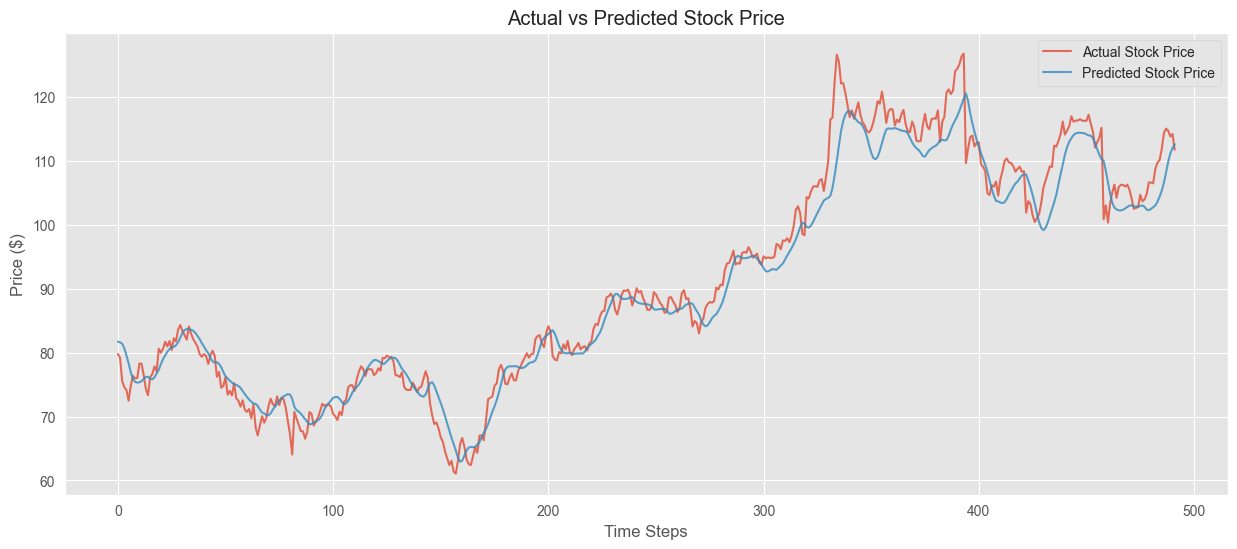

In [ ]:
# Plot only the results
plt.figure(figsize=(15, 6))
plt.plot(val_actual, label='Actual Stock Price', alpha=0.8)
plt.plot(val_predictions, label='Predicted Stock Price', alpha=0.8)
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()